In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [8]:
class SMO:
    def __init__(self, kernel=None, max_iter=10000, epsilon=0.001, C=1.0):
        if (kernel == None):
            self.kernel = lambda x1, x2 : np.dot(x1, x2.T)
        else:
            self.kernel = kernel
        self.epsilon = epsilon
        self.C = C
        self.max_iter = max_iter
        self.b = None
        self.w = None
    
    '''
    the function that predict the class of an sample thanks to the normal vector w and b
    '''
    def h(self, X):
        return np.sign(np.dot(self.w, X.T) - self.b).astype(int)
    
    '''
    the function that computes the w vector thanks to Lagrange multipliers alpha
    '''
    def compute_w(self, alphas, X, y):
        w = 0
        for i in range(X.shape[0]):
            w += alphas[i] * y[i] * X[i,:]
        self.w = w
    
    def randexclusif(self, mn, mx, excl):
        res = random.randint(mn, mx)
        while (res == excl):
            res = random.randint(mn, mx)
        return res
    
    def fit(self, X, y):
        self.b = 0
        size = (X.shape[0])
        alphas = np.zeros((size))
        for count in range(self.max_iter):
            prev_alphas = np.copy(alphas)
            for i in range(size):
                y1 = y[i]
                x1 = X[i, :]
                alpha1 = alphas[i]
                
                self.compute_w(alphas, X, y)
                Ei = self.h(x1) - y1
                if ((Ei*y1 < -self.epsilon and alpha1 < self.C) or (Ei*y1 > self.epsilon and alpha1 > 0)):
                    #selection of j != i for a simplified SMO method
                    j = self.randexclusif(0, size - 1, i)
                    y2 = y[j]
                    x2 = X[j, :]
                    alpha2 = alphas[j]
                    
                    Ej = self.h(x2) - y2
                    
                    if (y1 == y2):
                        L = max(0, alpha2 + alpha1 - self.C)
                        H = min(self.C, alpha2 + alpha1)
                    else:
                        L = max(0, alpha2 - alpha1)
                        H = min(self.C, self.C + alpha2 - alpha1)
                    
                    if (L == H):
                        continue
                    
                    nu = self.kernel(x1, x1) + self.kernel(x2, x2) - 2 * self.kernel(x1, x2)
                    
                    if (nu < 0):
                        print("nu < 0")
                        print(nu)
                        continue
                
                    a2 = alpha2 + float(y2 * (Ei - Ej)) / nu
                    if (a2 > H):
                        a2 = H
                    elif (a2 < L):
                        a2 = L
                    alphas[j] = a2
                    
                    if (abs(a2 - alpha2) < self.epsilon):
                        continue
                    
                    alphas[i] = alpha1 + y1 * y2 * (alpha2 - a2)
                    b1 = Ei + y1 * (alphas[i] - alpha1) * self.kernel(x1, x1) + y2 * (a2 - alpha2) * self.kernel(x1, x2) + self.b
                    b2 = Ej + y1 * (alphas[i] - alpha1) * self.kernel(x1, x2) + y2 * (a2 - alpha2) * self.kernel(x2, x2) + self.b
                    
                    if (alphas[i] > 0 and alphas[i] < self.C):
                        self.b = b1
                    elif (a2 > 0 and a2 < self.C):
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2
            diff = np.linalg.norm(alphas - prev_alphas)
            if diff < self.epsilon:
                break
        self.compute_w(alphas, X, y)
        return alphas

    def predict(self, X):
        return self.h(X)

In [9]:
from sklearn.datasets import make_classification
from sklearn.utils import shuffle

def generate_linear_problem(size, percent=0.2):
    separable = False
    while not separable:
        samples = make_classification(n_samples=size, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, flip_y=-1)
        red = samples[0][samples[1] == 0]
        blue = samples[0][samples[1] == 1]
        separable = any([red[:, k].max() < blue[:, k].min() or red[:, k].min() > blue[:, k].max() for k in range(2)])
    red = np.array([np.append(red[i], -1) for i in range(len(red))])
    blue = np.array([np.append(blue[i], 1) for i in range(len(blue))])
    perc = int(percent * size)
    trainr = red[:perc]
    testr = red[perc:]
    trainb = blue[:perc]
    testb = blue[perc:]
    res = np.append(trainr, trainb, axis=0)
    res = shuffle(res)
    res2 = np.append(testr, testb, axis=0)
    res2 = shuffle(res)
    X = res[:,:2]
    y = res[:,-1]
    Xtest = res2[:,:2]
    ytest = res2[:,-1]
    return X, y, Xtest, ytest

In [10]:
X, y, Xtest, ytest = generate_linear_problem(500)

No handles with labels found to put in legend.


accuracy train:	1.000
accuracy test:	1.000


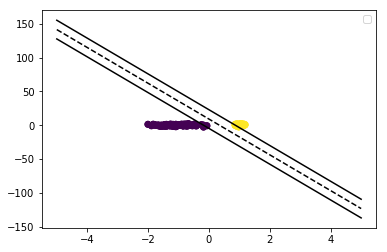

In [11]:
model = SVC(kernel='linear', C = 1.0)
# Fit model
alphas = model.fit(X, y)
# Make prediction
y_hat = model.predict(X)
y_hattest = model.predict(Xtest)
# Calculate accuracy
acc = accuracy_score(y, y_hat)
acc2 = accuracy_score(ytest, y_hattest)
print("accuracy train:\t%.3f" % (acc))
print("accuracy test:\t%.3f" % (acc2))
w = model.coef_[0]


xx = np.linspace(-5,5)
yy = - 1 * (xx*w[0] + model.intercept_) / w[1]
yy1 = - 1 * (xx*w[0] + model.intercept_ - 1) / w[1]
yy2 = - 1 * (xx*w[0] + model.intercept_ + 1) / w[1]
h0 = plt.plot(xx, yy, 'k--')
h1 = plt.plot(xx, yy1, 'k-')
h2 = plt.plot(xx, yy2, 'k-')

plt.scatter(X[:, 0], X[:, 1], c = y)
plt.scatter(Xtest[:, 0], Xtest[:, 1], c = ytest)
plt.legend()
plt.show()

No handles with labels found to put in legend.


accuracy train:	1.000
accuracy test:	1.000
1.0
[2.35727707 0.65474966]


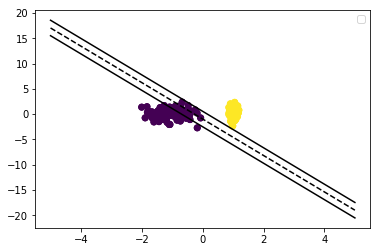

In [12]:
model = SMO()
# Fit model
alphas = model.fit(X, y)
# Make prediction
y_hat = model.predict(X)
y_hattest = model.predict(Xtest)
# Calculate accuracy
acc = accuracy_score(y, y_hat)
acc2 = accuracy_score(ytest, y_hattest)
print("accuracy train:\t%.3f" % (acc))
print("accuracy test:\t%.3f" % (acc2))
print(accuracy_score(ytest, y_hattest))
w = model.w
print(w)

xx = np.linspace(-5,5)
yy = - 1 * (xx*w[0] + model.b) / w[1]
yy1 = - 1 * (xx*w[0] + model.b - 1) / w[1]
yy2 = - 1 * (xx*w[0] + model.b + 1) / w[1]
h0 = plt.plot(xx, yy, 'k--')
h1 = plt.plot(xx, yy1, 'k-')
h2 = plt.plot(xx, yy2, 'k-')


plt.scatter(X[:, 0], X[:, 1], c = y)
plt.scatter(Xtest[:, 0], Xtest[:, 1], c = ytest)
plt.legend()
plt.show()